# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imresize , imread  #This is getting an import error
import datetime
import os
import cv2

import imageio #using as an alternative to imread
from PIL import Image #using as an alternative to imread

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture_Recognition/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, 18, 84, 84, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])

                for idx, item in enumerate(img_idx):
                    image = imageio.imread(
                        source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[
                            item]).astype(np.float32)

                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (84, 84)).astype(np.float32)
                    else:
                        image = cv2.resize(image, (84, 84)).astype(np.float32)

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] - np.mean(image[:, :, 0])
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] - np.mean(image[:, :, 1])
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] - np.mean(image[:, :, 2])

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Remaining data points
        if len(t) % batch_size != 0:
            batch_data = np.zeros((len(t) % batch_size, 18, 84, 84, 3))
            batch_labels = np.zeros((len(t) % batch_size, 5))

            for folder in range(len(t) % batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * (len(t) % batch_size))].split(';')[0])

                for idx, item in enumerate(img_idx):
                    image = imageio.imread(
                        source_path + '/' + t[folder + (batch * (len(t) % batch_size))].strip().split(';')[0] + '/' +
                        imgs[item]).astype(np.float32)

                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (84, 84)).astype(np.float32)
                    else:
                        image = cv2.resize(image, (84, 84)).astype(np.float32)

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] - np.mean(image[:, :, 0])
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] - np.mean(image[:, :, 1])
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] - np.mean(image[:, :, 2])

                batch_labels[folder, int(t[folder + (num_batches * (len(t) % batch_size))].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Gesture_Recognition/Project_data/train'
val_path = '/content/gdrive/MyDrive/Gesture_Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# Input shape for Conv2D+GRU
input_shape = (18, 84, 84, 3)

model = Sequential()

# First Convolutional Layer
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same'), input_shape=(18, 84, 84, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))

# Second Convolutional Layer
model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))

# Third Convolutional Layer
model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))

# Fourth Convolutional Layer
model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))

# GRU layer
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(GRU(512, return_sequences=True, dropout=0.5))
model.add(GRU(512, return_sequences=False, dropout=0.5))

# Flatten the output before fully connected layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer with softmax activation for classification
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, 18, 84, 84, 64)    1792      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 18, 84, 84, 64)    256       
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 18, 84, 84, 64)    0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 18, 42, 42, 64)    0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 18, 42, 42, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6364 - categorical_accuracy: 0.2353Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.60019, saving model to model_init_2023-12-1309_53_44.374874/model-00001-1.63638-0.23529-1.60019-0.25000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.6364 - categorical_accuracy: 0.2353 - val_loss: 1.6002 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5560 - categorical_accuracy: 0.2941
Epoch 2: val_loss did not improve from 1.60019
21/21 [==============================] - 72s 4s/step - loss: 1.5560 - categorical_accuracy: 0.2941 - val_loss: 1.7978 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4

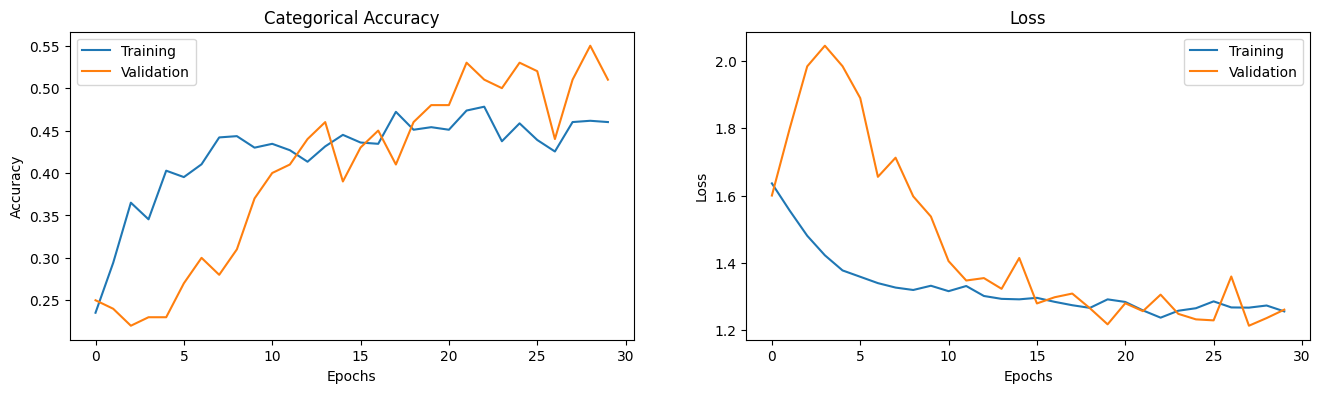

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plot accuracy
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].set_title('Categorical Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Training', 'Validation'])

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(['Training', 'Validation'])

plt.show()